In this notebook, the linear AE + SVD of [Plaut, 2018] is used to extract PCA factors. The AE implementation is heavily guided by the replication code provided by the author.

The structure of the autoencoder is: Input (120) → Dense(3, linear) → Dense(120, linear) → Output (120).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers, models, optimizers
from keras.layers import Input, Dense
from sklearn.decomposition import PCA
from plotting_utils import plot_yield_loadings, plot_keras_training_loss, plot_marginal_r_squares
from data_utils import load_yield_data, load_fred_md
from seed_utils import set_random_seed
set_random_seed(1)


yield_data = load_yield_data()
FIRST_DATE = yield_data.index.min() - pd.DateOffset(months=1)
LAST_DATE = yield_data.index.max()

In [2]:
def analyticalPCA(y, dimension):
    pca = PCA(n_components=dimension)
    pca.fit(y)
    return pca.components_, pca.transform(y)

def linearAE(y, dimension=3, learning_rate = 1e-4, regularization = 5e-4, epochs=100):
    """Train a linear autoencoder on yield data y to extract 'dimension' factors."""
    input_layer = Input(shape=(y.shape[1],))

    encoded = Dense(dimension, activation='linear',
                    kernel_regularizer=regularizers.l2(regularization))(input_layer)
    decoded = Dense(y.shape[1], activation='linear',
                    kernel_regularizer=regularizers.l2(regularization))(encoded)
    
    autoencoder = models.Model(input_layer, decoded)
    autoencoder.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')

    history = autoencoder.fit(
        y, y, 
        epochs=epochs, 
        batch_size=32, 
        shuffle=True, 
        verbose=0,
    )

    (w1, b1, w2, b2) = autoencoder.get_weights()
    return (w1, b1, w2, b2, history, autoencoder)

Next, I calculate the PCA and linear AE factors:

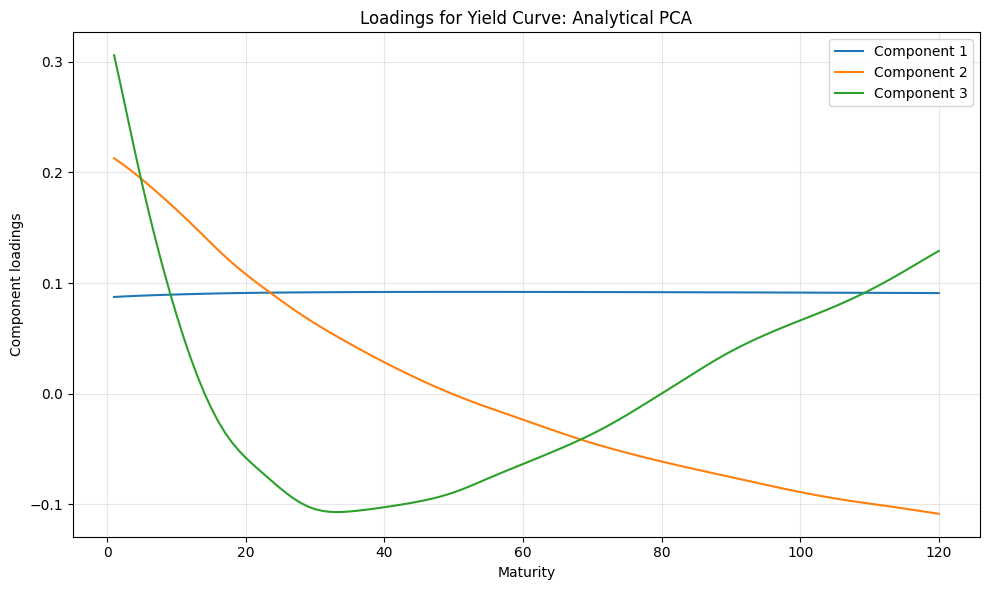

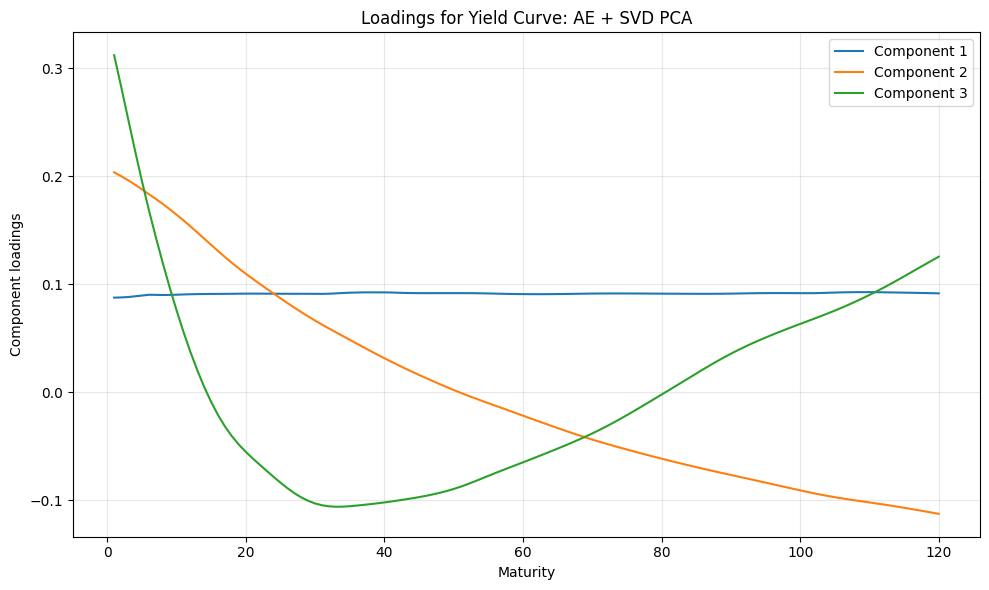

In [3]:
# Convert yield data to numpy array and normalize
y = yield_data.values.astype('float32')
# Standardize the data (mean=0, std=1 for each maturity)
y_mean = np.mean(y, axis=0)
y_std = np.std(y, axis=0)
y_normalized = (y - y_mean) / y_std

p_analytical, pca_scores = analyticalPCA(y_normalized, dimension=3)

# Train the linear autoencoder
(w1, b1, w2, b2, history, autoencoder) = linearAE(y_normalized, dimension=3, learning_rate=1e-3, regularization=1e-4, epochs=50)

# PCA by applying SVD to linear autoencoder weights as in paper
(p_linear_ae, _, _) = np.linalg.svd(w2.T, full_matrices=False)

# NB: Invert C3 to match PCA sign (must be done on a seed-to-seed basis)
# In the paper it is also noted that the sign is arbitrary (p. 4), so this is just for visual matching
p_linear_ae[:, 2] = -p_linear_ae[:, 2]

# Plot results
plot_yield_loadings(p_analytical, 'Analytical PCA')
plot_yield_loadings(p_linear_ae.T, 'AE + SVD PCA')

(For completeness, I also plot the training loss, though it is not very interesting here)

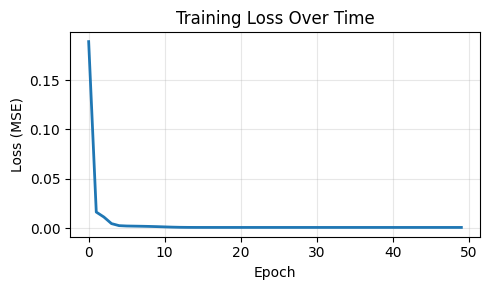

In [4]:
plot_keras_training_loss(history)

Having shown that the loadings are equal, I proceed to construct time series score dataframe like in `1PCA.ipynb` and plot the score of each component's marginal squared Pearson correlation with the FRED-MD macro factors.

The AE+SVD scores are extracted as by PCA, a projection of the data onto the principal components (loadings). The alternative is to pass each date into the encoder part of the AE and take the input. However, the AE has been trained to minimize reconstruction error, not maximize variance, and therefore these two methods differ.

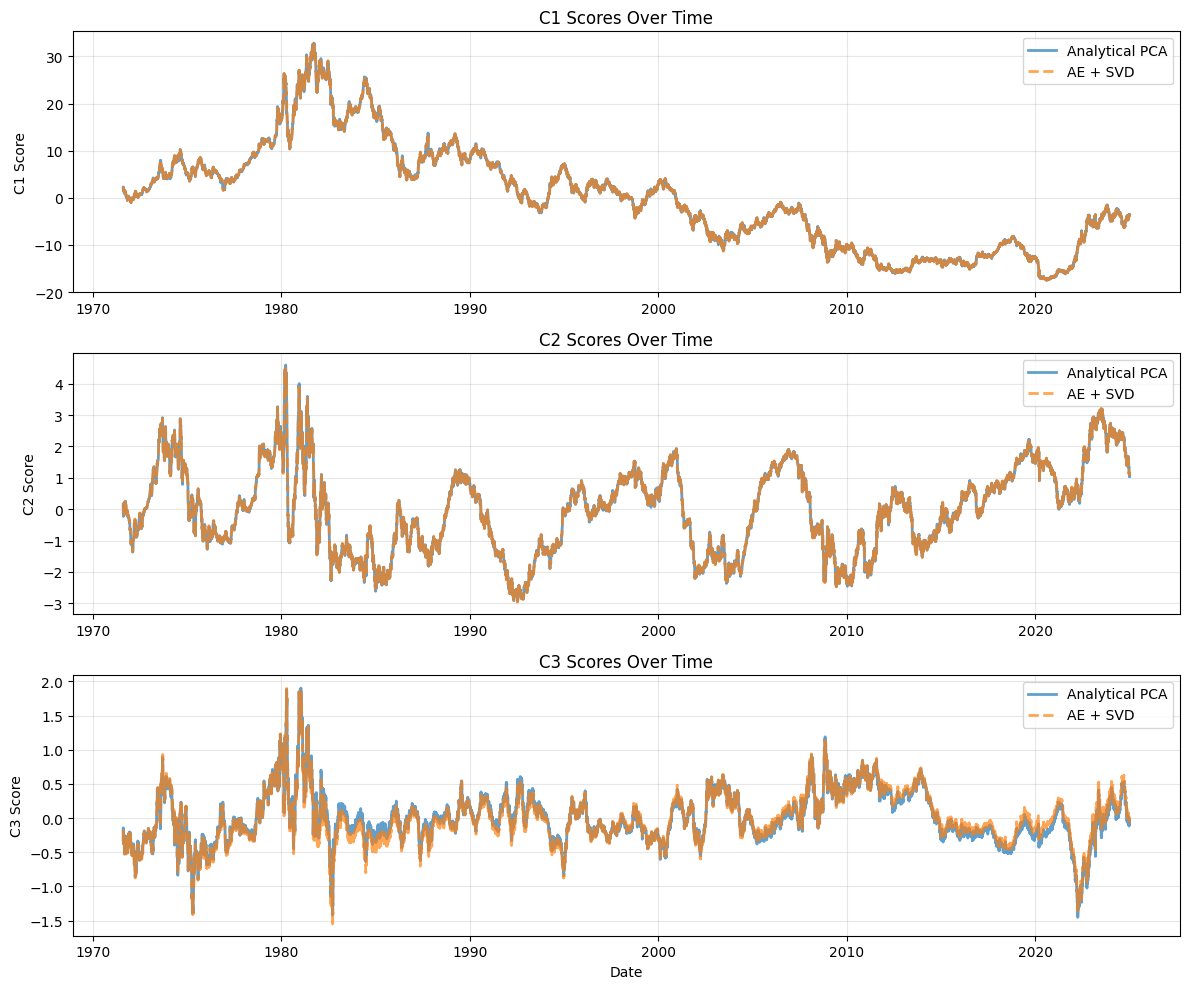

In [5]:
# Extract AE scores
ae_scores_projected = y_normalized @ p_linear_ae 

pca_scores_df = pd.DataFrame(
    pca_scores,
    index=yield_data.index,
    columns=['C1', 'C2', 'C3']
)

ae_scores_df = pd.DataFrame(
    ae_scores_projected, 
    index=yield_data.index, 
    columns=['C1', 'C2', 'C3']
)

# Write AE + SVD scores to csv
ae_scores_df.to_csv(r'scores/ae_svd_scores.csv')

# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
for i, pc in enumerate(['C1', 'C2', 'C3']):
    axes[i].plot(pca_scores_df.index, pca_scores_df[pc], 
                 label='Analytical PCA', alpha=0.7, linewidth=2)
    axes[i].plot(ae_scores_df.index, ae_scores_df[pc], 
                 label='AE + SVD', alpha=0.7, linewidth=2, linestyle='--')
    axes[i].set_ylabel(f'{pc} Score')
    axes[i].set_title(f'{pc} Scores Over Time')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

axes[2].set_xlabel('Date')
plt.tight_layout()
plt.show()

Above we have seen that the scores are equal, again, for completeness, I plot the FRED-MD marginals for the AE+SVD PCA:

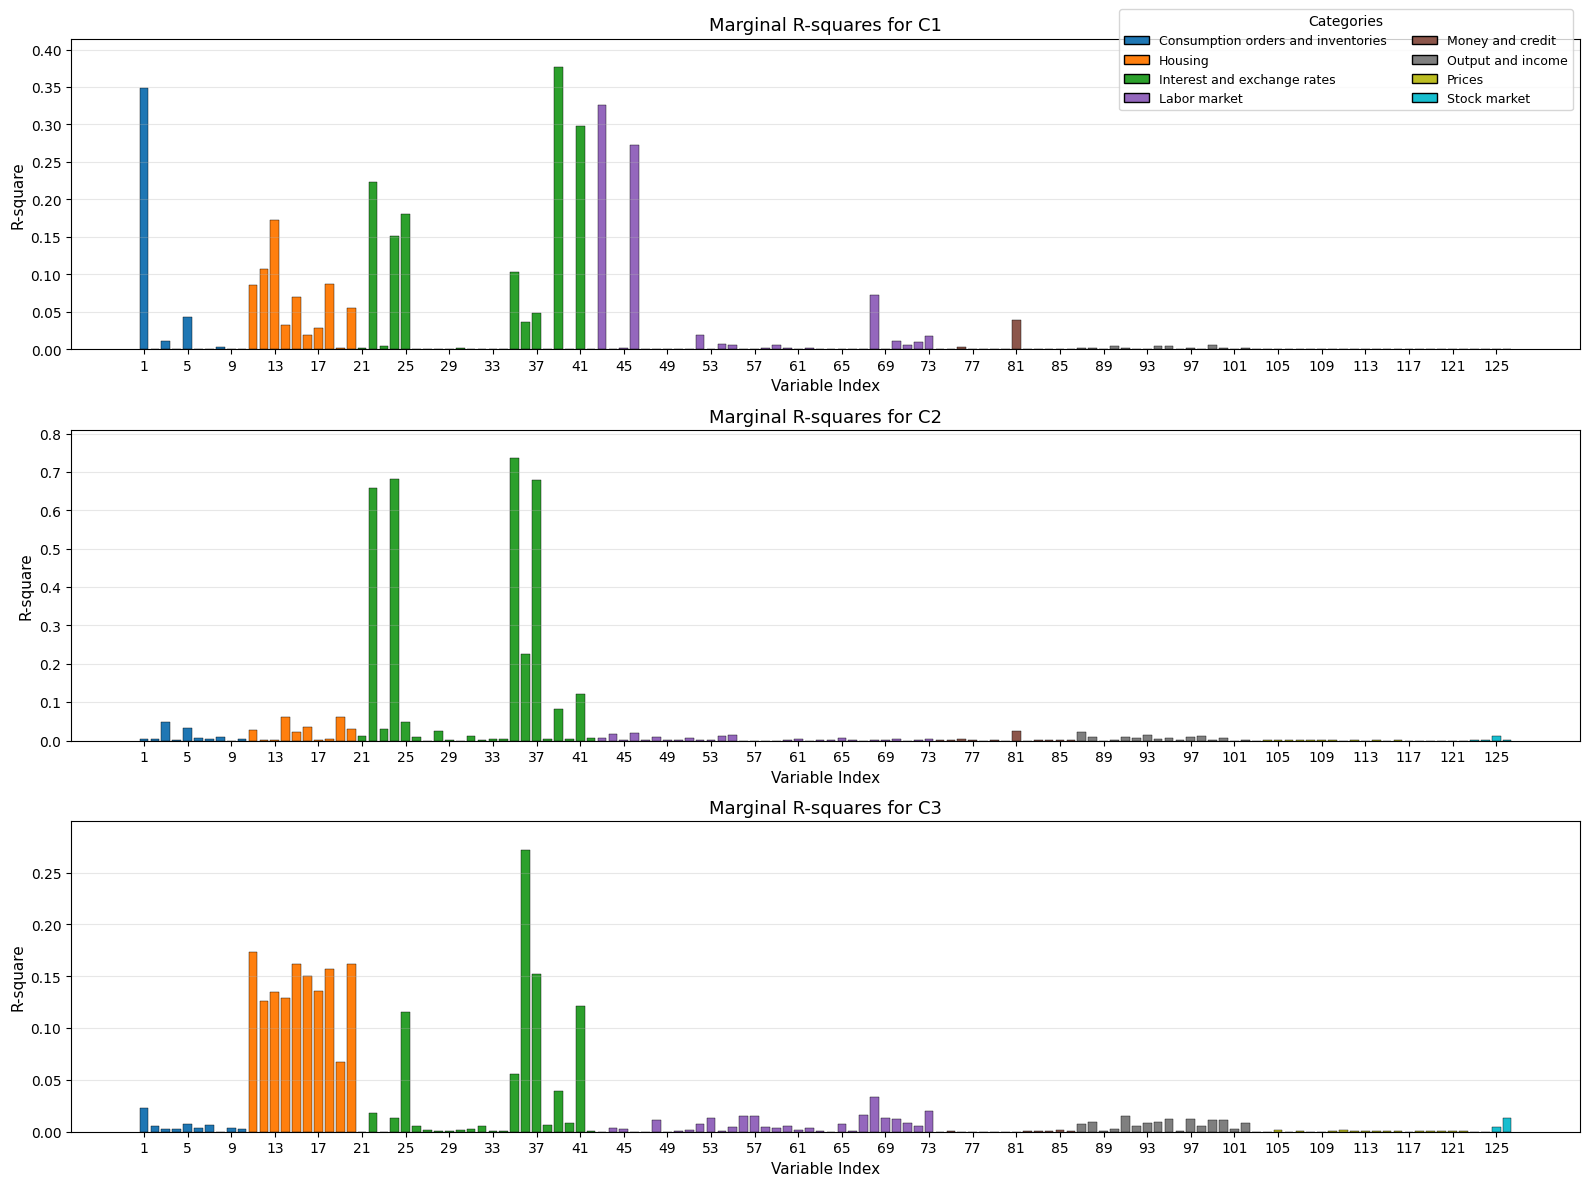

In [6]:
fred_md = load_fred_md(FIRST_DATE, LAST_DATE)

# Resample AE+SVD scores to monthly for FRED-MD comparison
ae_scores_monthly = ae_scores_df.resample('MS').first()

plot_marginal_r_squares(fred_md, ae_scores_monthly)

References: 

* Plaut, Elad. 2018. “From Principal Subspaces to Principal Components with Linear Autoencoders."
* The provided replication code: https://github.com/plaut/linear-ae-pca/blob/master/LinearAE_PCA_MNIST.py